https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import numpy as np
import math
from sklearn.model_selection import train_test_split, cross_validate
import string

In [2]:
SARA_FILEPATH = '/Users/sarakent/Desktop/ML 1/TMDB_movie_dataset_v11.csv'
BECK_FILEPATH = 'C:/Users/becke/OneDrive/Documents/Northeastern Schoolwork/Spring 2024/DS 4400/TMDB_movie_dataset/TMDB_movie_dataset_v11.csv'

In [3]:
imdb_df = pd.read_csv(BECK_FILEPATH)
imdb_df['release_date'] = pd.to_datetime(imdb_df.release_date)
imdb_df = imdb_df[(imdb_df['status'] == 'Released') & 
        (imdb_df['budget'] > 10000) & 
        (imdb_df['release_date'].notna()) & 
        (imdb_df['genres'].notna()) &
        (imdb_df['runtime'] != 0) & 
        (imdb_df['release_date'] > '1950-01-01') &
        (imdb_df['tagline'].notna()) &
        (imdb_df['overview'].notna())]

In [4]:
imdb_df.head(1)

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages,keywords
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili","rescue, mission, dream, airplane, paris, franc..."


### Plot Revenue over Time

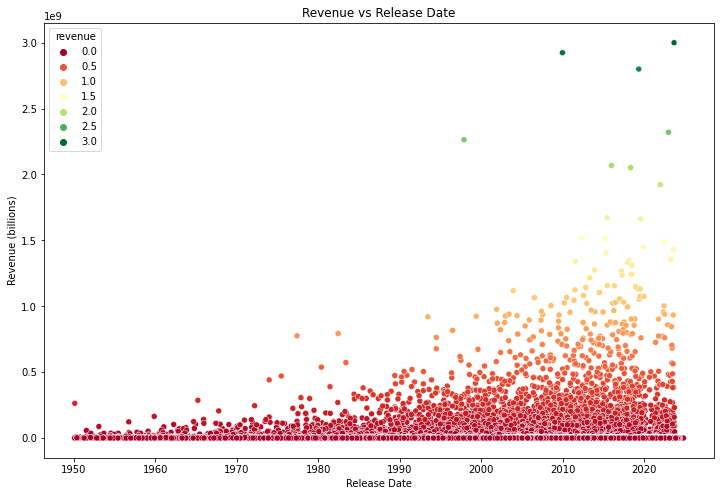

In [5]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=imdb_df, x='release_date', y='revenue', hue='revenue', palette='RdYlGn')

# labels and title
plt.xlabel('Release Date')
plt.ylabel('Revenue (billions)')
plt.title('Revenue vs Release Date')

plt.show()

### Look at Revenue vs Budget

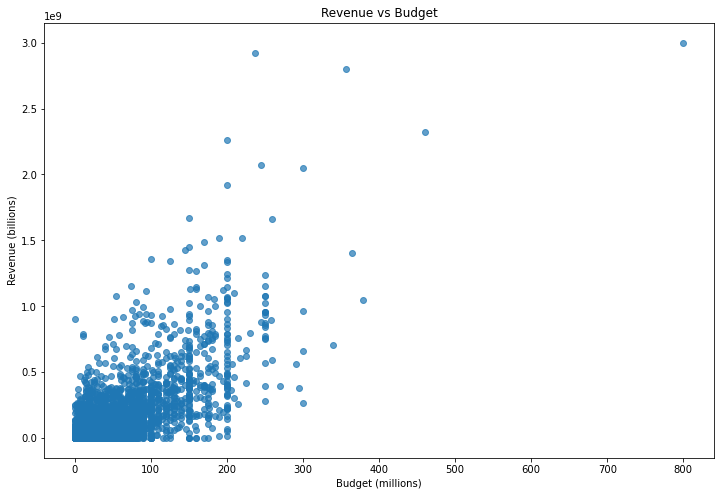

In [6]:
plt.figure(figsize=(12, 8))
plt.scatter(imdb_df['budget']/1e6, imdb_df['revenue'], alpha=0.7)

plt.xlabel('Budget (millions)')
plt.ylabel('Revenue (billions)')
plt.title('Revenue vs Budget')

plt.show()

### Now explore movies by country

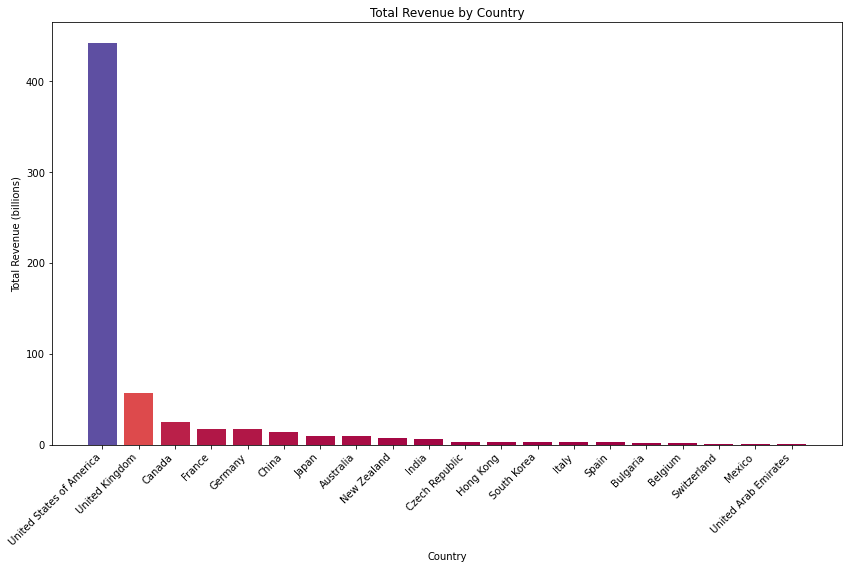

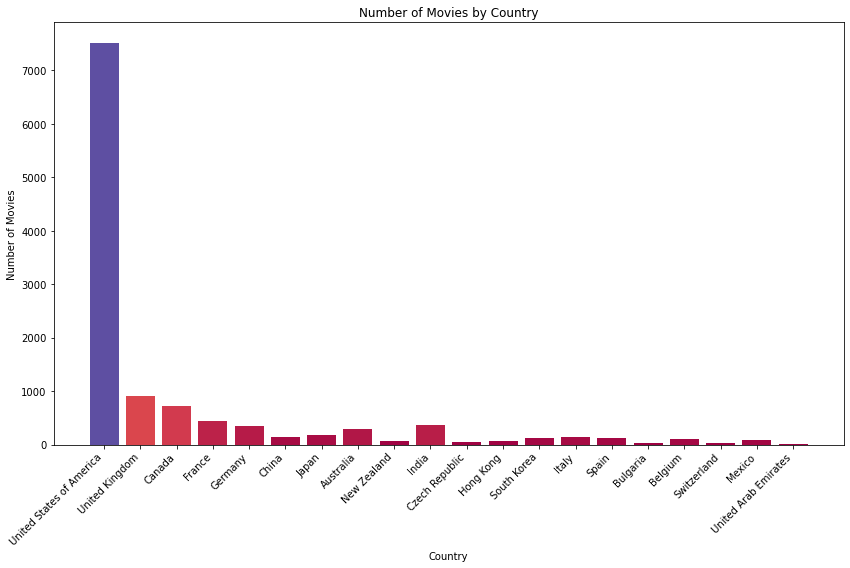

In [7]:
# data by country and sum the revenue for each country
imdb_df = imdb_df[imdb_df.production_countries.notna()]
imdb_df['country'] = imdb_df['production_countries'].apply(lambda x: str(x).split(',')[0])

revenue = imdb_df.groupby('country')['revenue'].sum().sort_values(ascending=False).head(20)

# filter to include only the top 20 countries by revenue
filtered_df = imdb_df[imdb_df['country'].isin(revenue.index)]

# colormap & normalize revenue
cmap = plt.cm.Spectral
normalize_revenue = plt.Normalize(vmin=min(revenue), vmax=max(revenue))

# movie counts by country for top revenue countries
movie_count = filtered_df['country'].value_counts().reindex(revenue.index).head(20)

# total revenue by country
plt.figure(figsize=(12, 8))
plt.bar(revenue.index, revenue.values / 1e9, color=cmap(normalize_revenue(revenue.values)))
plt.ylabel('Total Revenue (billions)')
plt.xlabel('Country')
plt.title('Total Revenue by Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# normalize the movie count values for cmap
normalize_movie_count = plt.Normalize(vmin=min(movie_count), vmax=max(movie_count))

# plot movie counts by country
plt.figure(figsize=(12, 8))
plt.bar(movie_count.index, movie_count.values, color=cmap(normalize_movie_count(movie_count.values)))
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Country')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Genre Specific Data Exploration

In [8]:
# Get the most significant genre and production company for each movie
imdb_df['genres'] = imdb_df['genres'].apply(lambda x: x.split(',')[0])
imdb_df['production_companies'] = imdb_df['production_companies'].apply(
    lambda x: x.split(',')[0] if isinstance(x,str) else x)

# Limit the release date to only the month of release
imdb_df['release_date'] = imdb_df['release_date'].apply(lambda x: x.month)

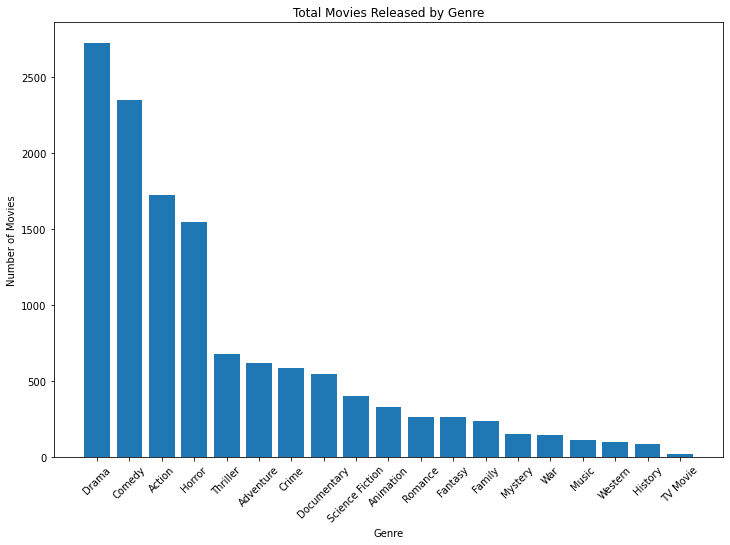

In [9]:
# Get the number of movies for each genre
genre_counts = imdb_df.genres.value_counts()

# Creating the bar chart
plt.figure(figsize=(12, 8))
plt.bar(genre_counts.index, genre_counts.values)
plt.title('Total Movies Released by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

### Production Company Exploration

In [10]:
# Make sure there are no Nan in the production companies
production_df = imdb_df.dropna(subset=['production_companies'])

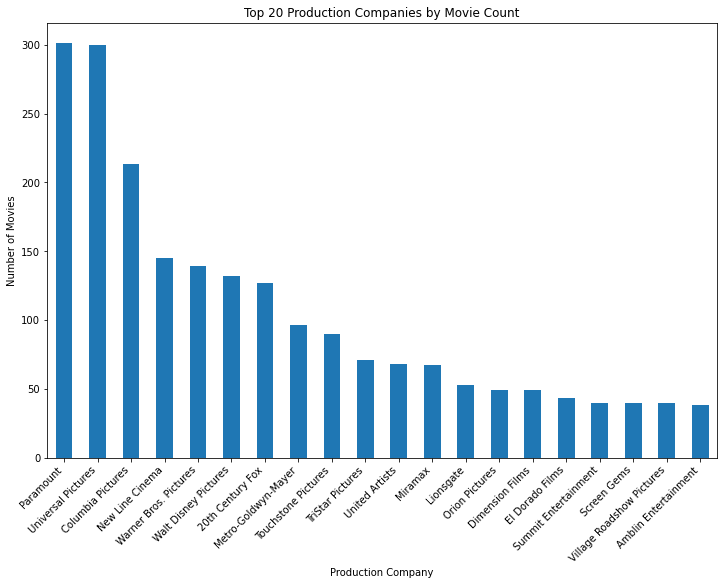

In [11]:
# Get the counts of movies for the top 20 production companies
production_counts = production_df['production_companies'].value_counts().head(20)

# Plotting the data
plt.figure(figsize=(12, 8))
production_counts.plot(kind='bar')
plt.title('Top 20 Production Companies by Movie Count')
plt.xlabel('Production Company')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.show()

In [12]:
# Count movies per production company and genre
genre_counts = production_df.groupby(['production_companies', 'genres']).size().unstack(fill_value=0)

# Sum the counts to find the top 20 production companies
top_companies = genre_counts.sum(axis=1).nlargest(20).index

# Filter the data to only include these top companies
top_genre_counts = genre_counts.loc[top_companies]

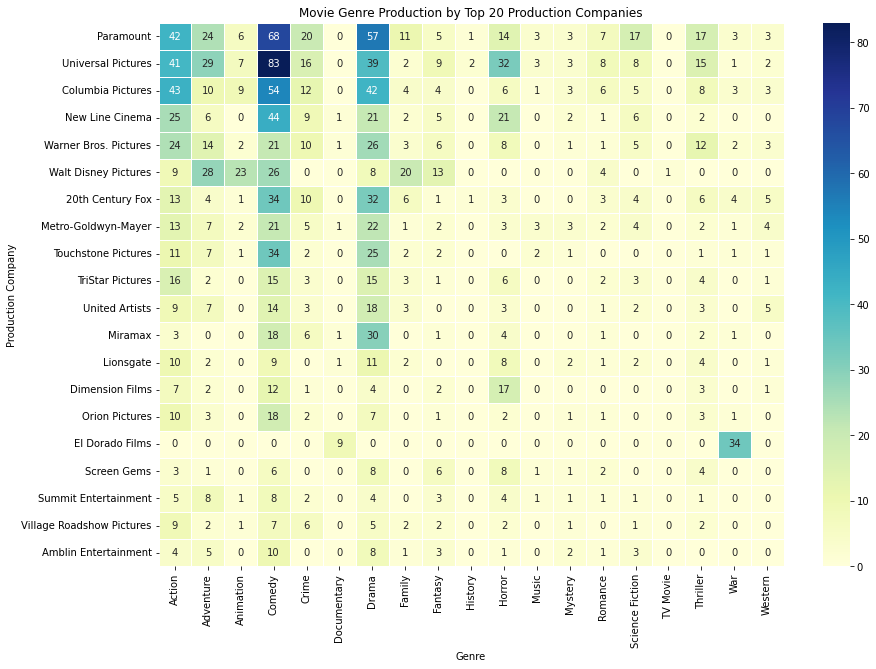

In [13]:
# Plot a heatmap between production companies and different genres
plt.figure(figsize=(14, 10))
sns.heatmap(top_genre_counts, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
plt.title('Movie Genre Production by Top 20 Production Companies')
plt.xlabel('Genre')
plt.ylabel('Production Company')
plt.show()

In [14]:
# Calculate the total movies produced by each company
company_totals = top_genre_counts.sum(axis=1)

# Calculate the percentage of each genre for each production company
genre_percentages = top_genre_counts.div(company_totals, axis=0) * 100

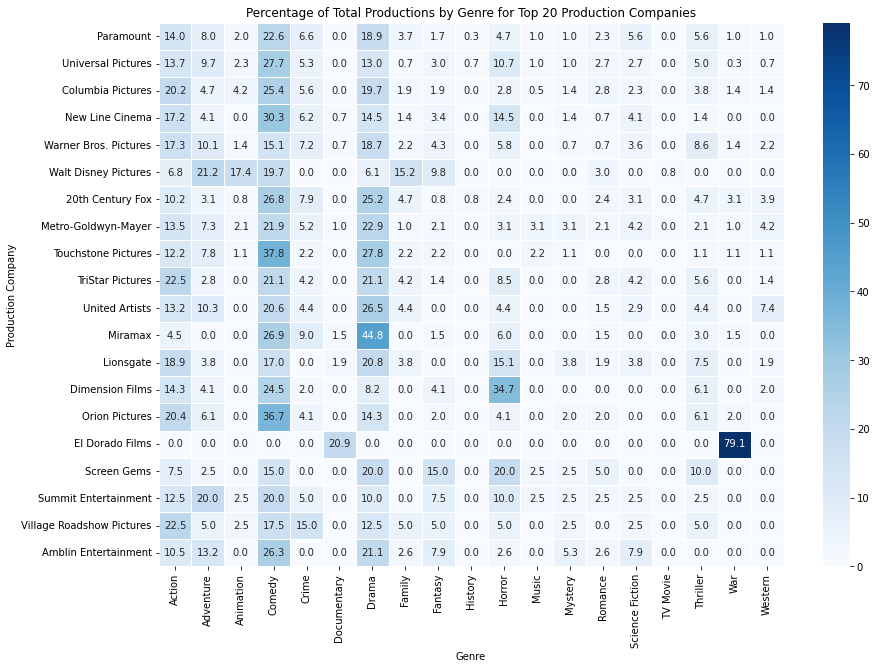

In [15]:
# Plot a heatmap for which percentage each genre takes up out of the production companies' total movies
plt.figure(figsize=(14, 10))
sns.heatmap(genre_percentages, annot=True, fmt=".1f", cmap="Blues", linewidths=.5)
plt.title('Percentage of Total Productions by Genre for Top 20 Production Companies')
plt.xlabel('Genre')
plt.ylabel('Production Company')
plt.show()

In [16]:
# Calculate the total movies for each genre across all companies
genre_totals = top_genre_counts.sum(axis=0)

# Calculate the percentage of each company's contribution to each genre
company_genre_percentages = (top_genre_counts.div(genre_totals, axis=1) * 100).fillna(0)

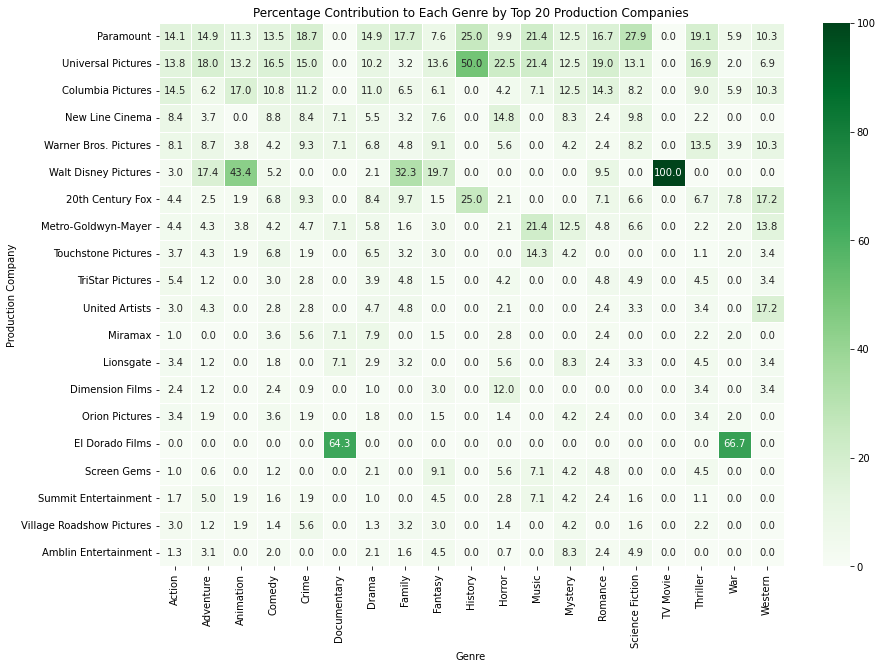

In [17]:
# Plot a heatmap for which percentage each production company takes up out of each genre's total movies
plt.figure(figsize=(14, 10))
sns.heatmap(company_genre_percentages, annot=True, fmt=".1f", cmap="Greens", linewidths=.5)
plt.title('Percentage Contribution to Each Genre by Top 20 Production Companies')
plt.xlabel('Genre')
plt.ylabel('Production Company')
plt.show()

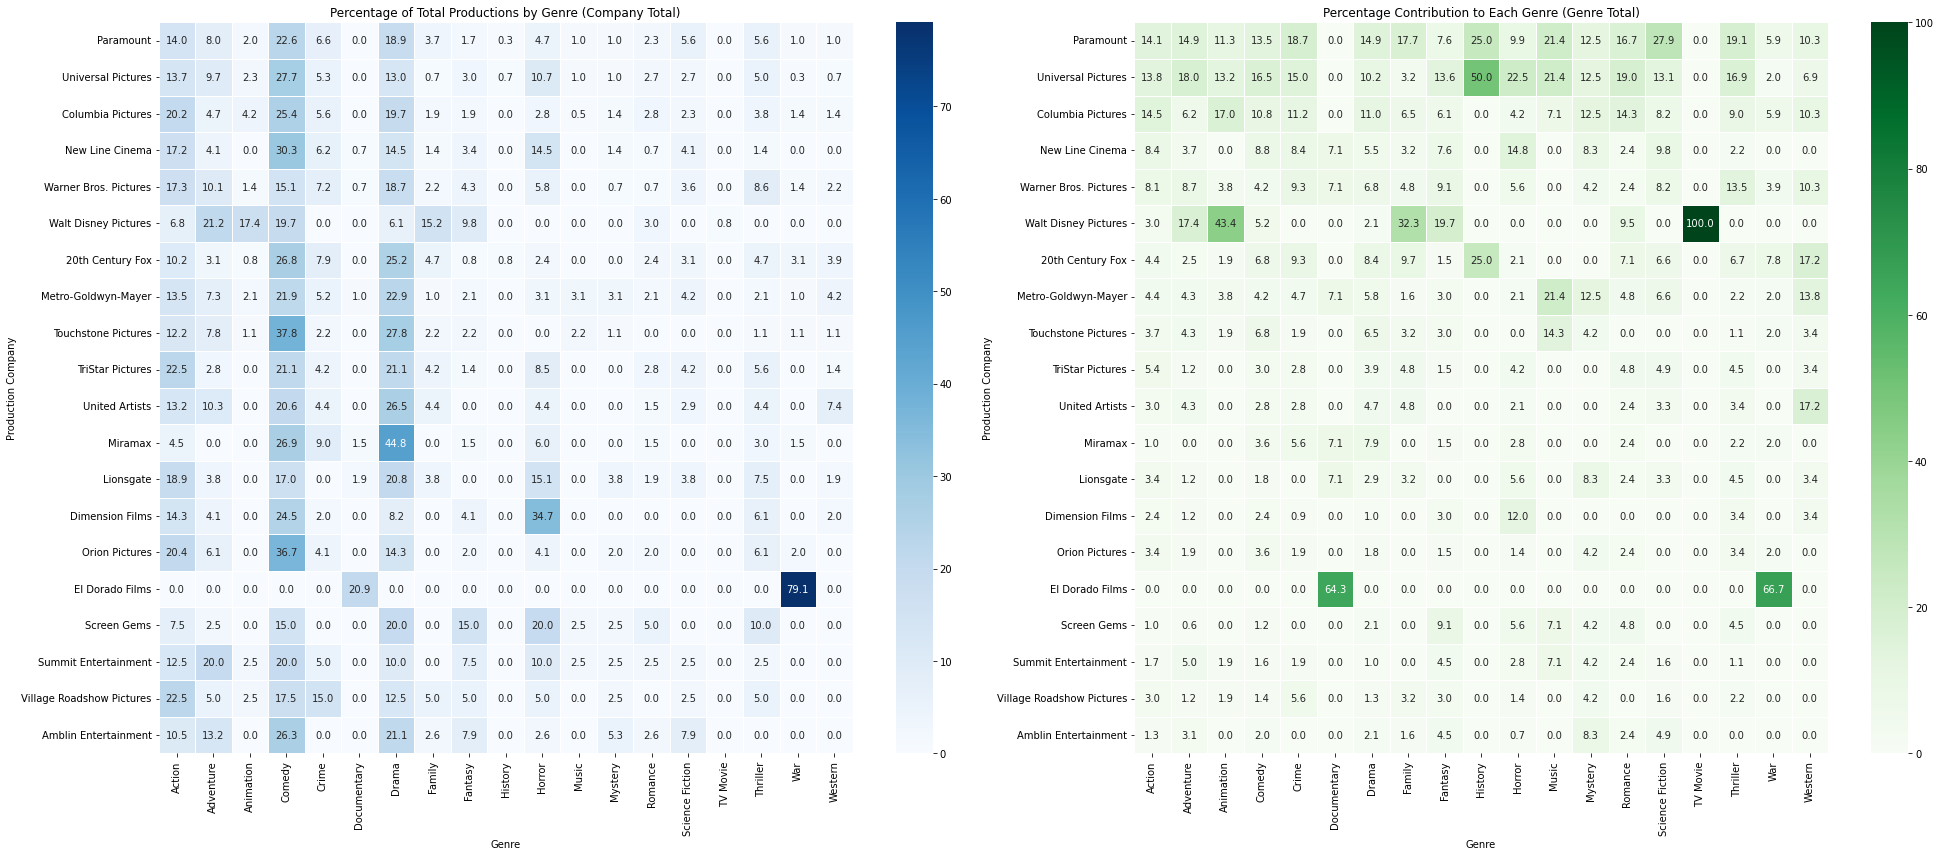

In [18]:
# Plot both heatmaps next to each other for easy comparison
fig, ax = plt.subplots(ncols=2, figsize=(28, 12))

# Heatmap for percentage of total productions by genre for each company
sns.heatmap(genre_percentages, annot=True, fmt=".1f", cmap="Blues", linewidths=.5, ax=ax[0])
ax[0].set_title('Percentage of Total Productions by Genre (Company Total)')
ax[0].set_xlabel('Genre')
ax[0].set_ylabel('Production Company')

# Heatmap for percentage contribution to each genre by company
sns.heatmap(company_genre_percentages, annot=True, fmt=".1f", cmap="Greens", linewidths=.5, ax=ax[1])
ax[1].set_title('Percentage Contribution to Each Genre (Genre Total)')
ax[1].set_xlabel('Genre')
ax[1].set_ylabel('Production Company')

plt.tight_layout()
plt.show()

### Release Date Exploration

In [19]:
# Create a dictionary to map month numbers to the month names
month_map = {
    1: "January", 2: "February", 3: "March", 4: "April",
    5: "May", 6: "June", 7: "July", 8: "August",
    9: "September", 10: "October", 11: "November", 12: "December"
}

# Drop columns without a release date and map the dictionary over the column
date_df = imdb_df.dropna(subset=['release_date'])
date_df['release_date'] = date_df['release_date'].map(month_map)

# Get the counts of movies for each month and reorder it in chronological order
monthly_counts = date_df['release_date'].value_counts().reindex([
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
])

monthly_counts

January       938
February      858
March        1096
April         966
May          1015
June         1068
July          942
August       1076
September    1336
October      1386
November     1040
December     1168
Name: release_date, dtype: int64

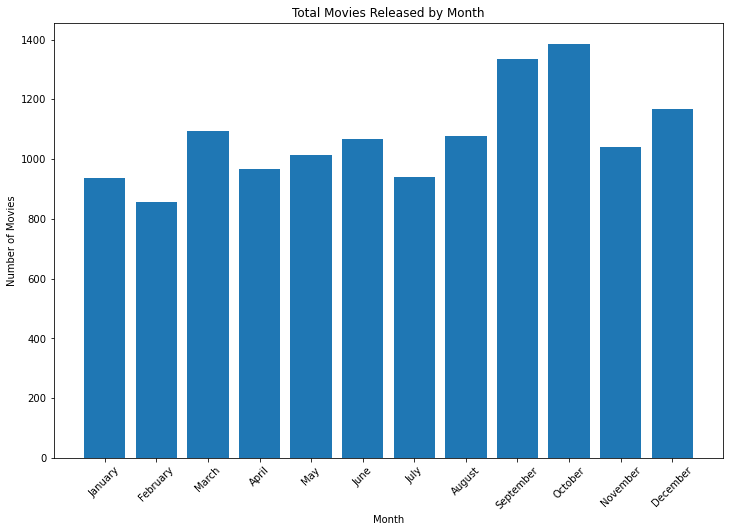

In [20]:
# Creating a bar chart of the counts
plt.figure(figsize=(12, 8))
plt.bar(monthly_counts.index, monthly_counts.values)
plt.title('Total Movies Released by Month')
plt.xlabel('Month')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

In [21]:
# Aggregate data: count movies by month and genre
month_genre_counts = date_df.groupby(['release_date', 'genres']).size().unstack(fill_value=0)

# Reindex to ensure all months are in proper order
month_genre_counts = month_genre_counts.reindex([
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
])

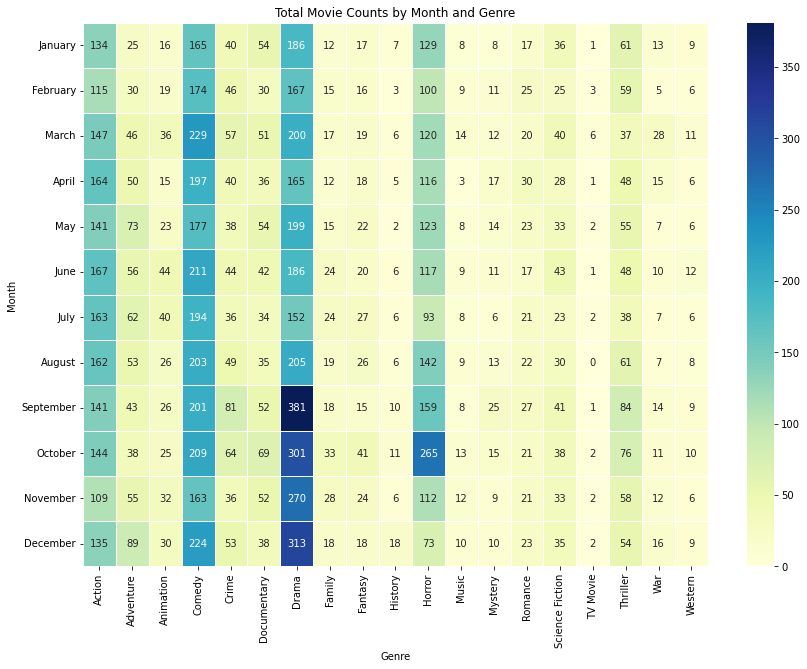

In [22]:
# Plot a heatmap for counts of movies in each month
plt.figure(figsize=(14, 10))
sns.heatmap(month_genre_counts, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
plt.title('Total Movie Counts by Month and Genre')
plt.xlabel('Genre')
plt.ylabel('Month')
plt.show()

In [23]:
# Calculate the total movies produced each month
month_totals = month_genre_counts.sum(axis=1)

# Calculate the percentage of each genre for each month
genre_percentages_by_month = month_genre_counts.div(month_totals, axis=0) * 100

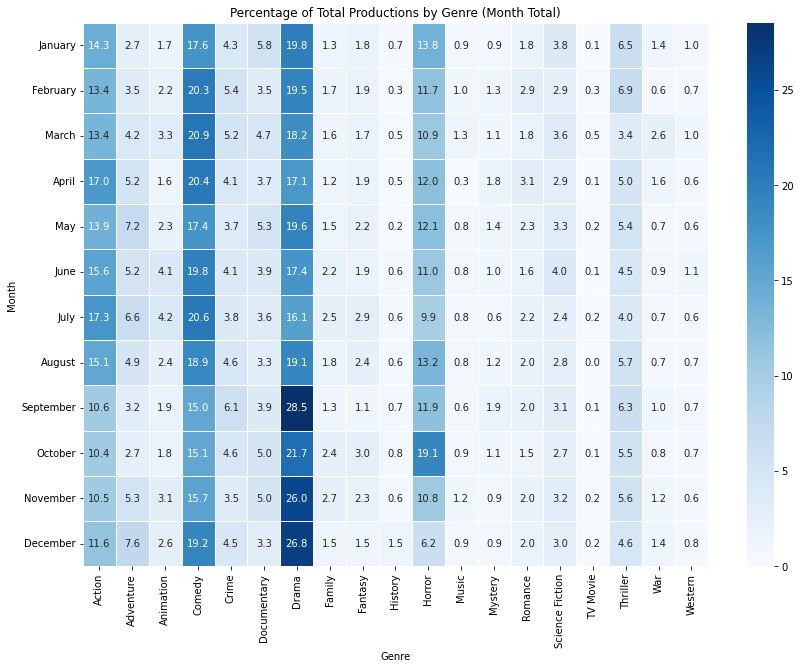

In [24]:
# Plot a heatmap for the splits of genres within each month
plt.figure(figsize=(14, 10))
sns.heatmap(genre_percentages_by_month, annot=True, fmt=".1f", cmap="Blues", linewidths=.5)
plt.title('Percentage of Total Productions by Genre (Month Total)')
plt.xlabel('Genre')
plt.ylabel('Month')
plt.show()

In [25]:
# Calculate the total movies for each genre across all months
genre_totals = month_genre_counts.sum(axis=0)

# Calculate the percentage contribution of each month to each genre
month_genre_percentages = month_genre_counts.div(genre_totals, axis=1) * 100

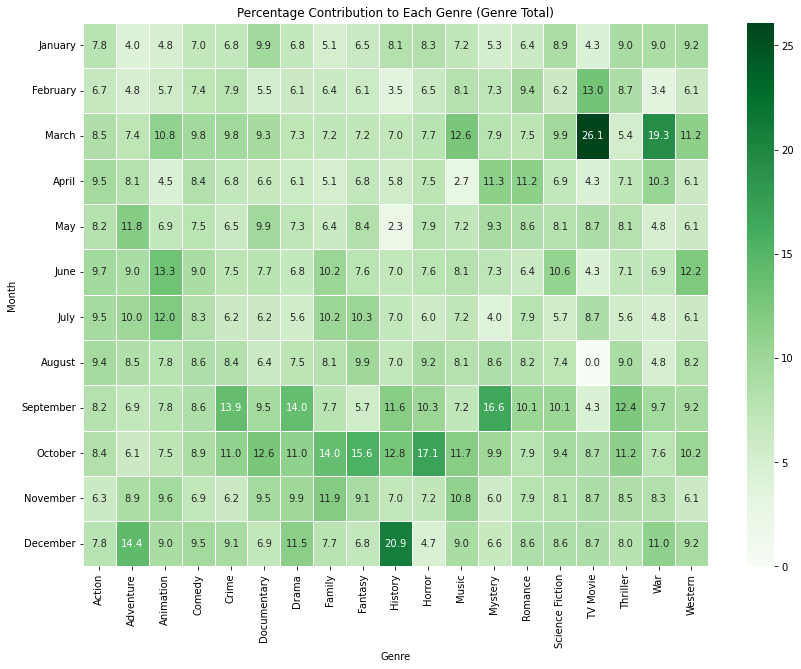

In [26]:
# Plot a heatmap for the splits of months within each genre
plt.figure(figsize=(14, 10))
sns.heatmap(month_genre_percentages, annot=True, fmt=".1f", cmap="Greens", linewidths=.5)
plt.title('Percentage Contribution to Each Genre (Genre Total)')
plt.xlabel('Genre')
plt.ylabel('Month')
plt.show()

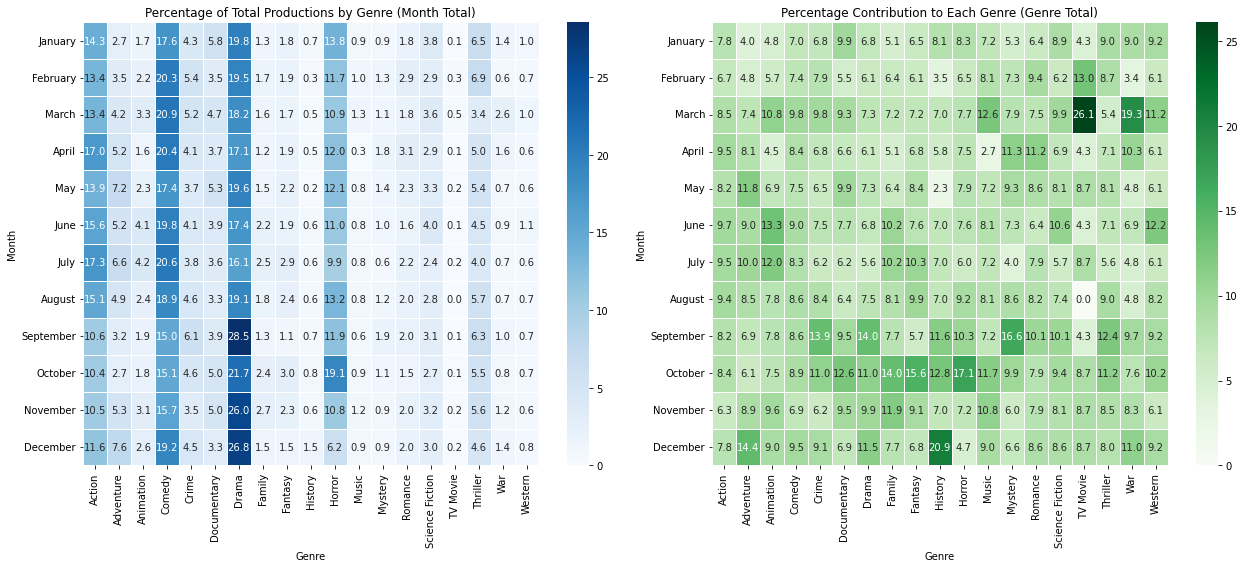

In [27]:
# Create subplots of both heatmaps next to each other
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# Heatmap 1: Percentage of Total Productions by Genre (Month Total)
sns.heatmap(genre_percentages_by_month, annot=True, fmt=".1f", cmap="Blues", linewidths=.5, ax=axes[0])
axes[0].set_title('Percentage of Total Productions by Genre (Month Total)')
axes[0].set_xlabel('Genre')
axes[0].set_ylabel('Month')

# Heatmap 2: Percentage Contribution to Each Genre (Genre Total)
sns.heatmap(month_genre_percentages, annot=True, fmt=".1f", cmap="Greens", linewidths=.5, ax=axes[1])
axes[1].set_title('Percentage Contribution to Each Genre (Genre Total)')
axes[1].set_xlabel('Genre')
axes[1].set_ylabel('Month')

plt.tight_layout()
plt.show()

# Setting up Word Freq Dataset

In [28]:
# Downloads: uncomment if you haven't done it yet
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt')

# function to check if the word is in english. this uses sysnet
# to check if there's any meaningful definitions for the word
def is_english_word(word):
    return len(wordnet.synsets(word)) > 0

# function to remove stopwords and numbers from text
def preprocess_text(text):
    # lemmatizer : reduces word to dictionary form
    lemmatizer = WordNetLemmatizer()
    # stopwords : words that hold no meaning
    stop_words = set(stopwords.words('english'))
    stop_words.add('a')
    
    # tokenize text : split into words
    words = word_tokenize(text)
    words = [word for word in words if word not in string.punctuation]
    
    
    # remove stopwords, numbers, and single-character words
    # A IS STILL BEING INCLUDED: SOMEONE HELP PLS
    filtered_words = []
    for word in words:
        if word.lower() not in stop_words and not any(char.isdigit() for char in word)\
        and is_english_word(word.lower()):
            lemmatized = lemmatizer.lemmatize(word.lower())
            if len(lemmatized) > 1:
                filtered_words.append(lemmatized)
    
    # join the filtered words back into a single string
    processed_text = ' '.join(filtered_words)
    
    return processed_text

In [29]:
# remove the necessary Nan items and reset the index
imdb_df = imdb_df[imdb_df.tagline.notna() & imdb_df.overview.notna()]
imdb_df.reset_index(inplace=True)

In [30]:
# combine text fields into one & preprocess the text
imdb_df['text'] = imdb_df['original_title'] + ' ' + imdb_df['overview'] + ' ' + imdb_df['tagline']

# apply the preprocessing to the text
imdb_df['text'] = imdb_df['text'].apply(preprocess_text)
imdb_df['text']

0        inception skilled thief commits corporate espi...
1        interstellar adventure group explorer make use...
2        dark knight batman raise stake war crime help ...
3        avatar century paraplegic marine dispatched mo...
4        avenger unexpected enemy emerges threatens glo...
                               ...                        
12884    taboo wake tragic emotional event dobson lead ...
12885    thong girl outer space thong girl reluctantly ...
12886    four bottle finding get dream job decide going...
12887    sound scene south iran story musician omitted ...
12888    kali year old girl cambodia life grandmother l...
Name: text, Length: 12889, dtype: object

In [31]:
# Label encode the production companies such that each of the top 20 have a number and then the rest are an 'other' number

# Find the top 20 production companies
top_20_companies = imdb_df['production_companies'].value_counts().nlargest(20).index

# Create a dictionary for mapping the top 20 companies
company_mapping = {company: idx+1 for idx, company in enumerate(top_20_companies)}

# Map all other companies to 21
default_mapping = {company: 21 for company in imdb_df['production_companies'].unique() if company not in top_20_companies}
company_mapping.update(default_mapping)

# Apply the mapping to the dataframe
imdb_df['production_companies'] = imdb_df['production_companies'].map(company_mapping)

In [32]:
# Split the initial dataframe
x = imdb_df[['text', 'production_companies', 'release_date']]
y = imdb_df.genres

# Splitting data into training and testing sets, including the additional columns
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Separating the 'text' column for CountVectorizer processing
x_train_text = x_train['text']
x_test_text = x_test['text']

# Creating and fitting the CountVectorizer
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(x_train_text)

# Transform the training and testing text data using the fitted CountVectorizer
xtrain_count = count_vect.transform(x_train_text)
xtest_count = count_vect.transform(x_test_text)

# Convert the count matrices to DataFrames
train_df_text = pd.DataFrame(xtrain_count.toarray(), columns=count_vect.get_feature_names_out(), index=x_train.index)
test_df_text = pd.DataFrame(xtest_count.toarray(), columns=count_vect.get_feature_names_out(), index=x_test.index)

# Drop the 'text' column from the original x_train and x_test
x_train = x_train.drop(columns='text')
x_test = x_test.drop(columns='text')

# Merge the text features with the original x_train and x_test, keeping the same index
train_df = pd.concat([x_train, train_df_text], axis=1)
test_df = pd.concat([x_test, test_df_text], axis=1)

# Add y labels back to train_df and test_df as the first column
train_df.insert(0, 'genres', y_train)
test_df.insert(0, 'genres', y_test)

MemoryError: Unable to allocate 1.36 GiB for an array with shape (18842, 9666) and data type int64

In [ ]:
train_df

### Wordcloud on training set!

In [ ]:
# sum all the columns
word_freqs = train_df.iloc[:, 1:].sum(axis=0).to_dict()

# word cloud object
wordcloud = WordCloud(width=800, height=400, 
                      background_color='white',
                     colormap='viridis').generate_from_frequencies(word_freqs)

# display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# train_df.to_csv(r'/Users/sarakent/Desktop/ML 1/train_df.csv')
# test_df.to_csv(r'/Users/sarakent/Desktop/ML 1/test_df.csv')